In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys

np.random.seed(1) #to fix the results
rs = 2
 
file_path = 'outputfile.txt'
sys.stdout = open(file_path, "w")


#df = pd.read_csv('EURUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('GBPUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('NZDUSD_H3_200001030000_202107201800.csv', sep='\t')
df = pd.read_csv('USDCAD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('USDCHF_H3_200001030000_202107201800.csv', sep='\t')

df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)

#save the open for white reality check
openp = df['<OPEN>'].copy() #for the case we want to enter trades at the open



##build window momentum features
for n in list(range(1,21)):
    name = 'ret' + str(n)
    df[name] = df["<OPEN>"].pct_change(periods=n) #for trading with open
    
    

#build date time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values


#build target assuming we know today's open
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open

#df = np.log(df+1)

#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

#select the features (by dropping)
cols_to_drop = ["<OPEN>","<HIGH>","<LOW>","<CLOSE>","<TICKVOL>","<VOL>","<SPREAD>"]  #optional
df.drop(cols_to_drop, axis=1, inplace=True)

#distribute the df data into X inputs and y target
X = df.drop(['retFut1'], axis=1)
y = df[['retFut1']]

#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]


In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_regression #Mutual information for a continuous target. (non linear)
from sklearn.feature_selection import f_regression #F-value between label/feature for regression tasks. (linear)
import detrendPrice 
import WhiteRealityCheckFor1 
import math

def profit_ratio(y_true, y_pred):
    positions_arr = np.where(y_pred> 0,1,-1 )
    positions_arr = np.nan_to_num(positions_arr, nan=0.0)
    dailyRet_arr = positions_arr * y_true #calculate the daily returns of the system
    dailyRet_arr = np.nan_to_num(dailyRet_arr, nan=0.0)
    profits = np.where((dailyRet_arr >= 0), dailyRet_arr, 0)
    losses = np.where((dailyRet_arr < 0), dailyRet_arr, 0)
    profit_ratio = np.sum(profits)/np.sum(np.abs(losses))
    return profit_ratio
    

def information_coefficient(y_true, y_pred):
    rho, pval = spearmanr(y_true,y_pred) #spearman's rank correlation
    print (rho)
    return rho

def sharpe(y_true, y_pred):
    positions_arr = np.where(y_pred> 0,1,-1 )
    positions_arr = np.nan_to_num(positions_arr, nan=0.0)
    dailyRet_arr = positions_arr * y_true
    dailyRet_arr = np.nan_to_num(dailyRet_arr, nan=0.0)
    ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet_arr) / np.std(dailyRet_arr)
    return ratio

In [3]:
def profit_ratio_select(X, y):
    #Function taking two arrays X and y, and returning a pair of arrays (scores, pvalues) or a single array with scores.
    #Model: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression
    #crit_arr should be an array or zeros with as many samples as X
    crit_arr  = np.zeros(X.shape[1]) 
    #pval_arr should be an array or zeros with as many samples as X
    pval_arr = np.zeros(X.shape[1])
    #instantiate a scaler using StandardScaler
    scaler = StandardScaler() #scaler to scale the data
    #intantiate a regressor using Ridge (same model as the one in the pipeline)
    ridge = Ridge(alpha=1.0, random_state=rs) 
    #make sure X and y has no NaNs
    X = np.nan_to_num(X, nan=0.0) 
    y = np.nan_to_num(y, nan=0.0) 
    #put the first 50% of X samples in X_train_arr
    X_train_arr = X[:len(X)//2, :]  
    #put the second 50% of X samples in X_test_arr
    X_test_arr = X[len(X)//2:, :]
    #using scaler, scale the X_train_arr
    X_train_arr = scaler.fit_transform(X_train_arr)  #fit the scaler to the training data
    #using scaler, scale the X_test_arr
    X_test_arr = scaler.transform(X_test_arr)  #transform the test data using the fitted scaler
    #put the first 50% of y samples in y_train_arr
    y_train_arr = y[:len(y)//2]  ##### #put the first 50% of y samples in y_train_arr
    #put the second 50% of y samples in y_test_arr
    y_test_arr = y[len(y)//2:]  ##### #put the second 50% of y samples in y_test_arr

    for i in range(X.shape[1]): #trade using one column of X at a time, in a loop
        #fit the ridge  model to the scaled train data  (you will need to use .reshape(-1,1) on the input)
        ridge.fit(X_train_arr[:, i].reshape(-1, 1), y_train_arr)
        #predict with the  ridge model using scaled test data (you will need to use .reshape(-1,1) on the input)
        y_pred = ridge.predict(X_test_arr[:, i].reshape(-1, 1))
        y_true = y_test_arr
        pr = profit_ratio(y_true, y_pred) #calculate the profit ratio
        crit_arr[i] =  pr
        pval_arr[i] = 1-sigmoid(pr)
    return crit_arr, pval_arr


def information_coefficient_select(X, y):
    #Function taking two arrays X and y, and returning a pair of arrays (scores, pvalues) or a single array with scores.
    #Model: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression
    rho_arr = np.zeros(X.shape[1])
    pval_arr = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
         rho_arr[i], pval_arr[i] = spearmanr(y,X[:, i])
    return rho_arr, pval_arr

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [4]:
#myscorer = None #uses the default r2 score, not recommended
#myscorer = "neg_mean_absolute_error"
#myscorer = make_scorer(information_coefficient, greater_is_better=True)
#myscorer = make_scorer(sharpe, greater_is_better=True)
myscorer = make_scorer(profit_ratio, greater_is_better=True)

ridge = Ridge(max_iter=1000)

percentile = 50


In [24]:
"""
INSTRUCTIONS

copy the last selector line (it has "score_func=information_coefficient_select")
paste it right under 
substitute "score_func=information_coefficient_select" by "score_func=profit_ratio_select"
you should end up with 4 selector choices: 
f_pregression, mutual_info_regression, information_coefficient_select and profit_ratio_select
complete ridge_selperc_profit_ratio_WRC_results_incomplete.txt by
using these 4 selectors.
"""

# selector = SelectPercentile(score_func=f_regression, percentile=percentile) #linear criterion 
# selector = SelectPercentile(score_func=mutual_info_regression, percentile=percentile) #non linear criterion
# selector = SelectPercentile(score_func=information_coefficient_select, percentile=percentile) #non linear criterion
selector = SelectPercentile(score_func=profit_ratio_select, percentile=percentile) #non linear criterion



In [25]:
numeric_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler',StandardScaler()),
    ('selector',selector)])

categorical_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


print(x_train.dtypes)
numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
categorical_features_ix = x_train.select_dtypes(include=['int64']).columns

#this code just turns an index numeric_features_ix 
#into a list of column numbers [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
numeric_features_no = [] 
for i in numeric_features_ix: 
    numeric_features_no.append(df.columns.get_loc(i))    

categorical_features_no = [] 
for i in categorical_features_ix: 
    categorical_features_no.append(df.columns.get_loc(i))    

#transformer 3-element tuples can be: ('name', function or pipeline, column_number_list or column_index)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, numeric_features_no),
        ('cat', categorical_sub_pipeline, categorical_features_no)], remainder='passthrough')
    
#the second time a ColumnTransformer is used, 
#a list of column numbers must be passed as parameter because 
#the x_train dataframe has been transformed to an array inside the pipeline

pipe = Pipeline(steps=[('preprocessor',preprocessor),('ridge', ridge)])

a_rs = np.logspace(-7, 0, num=20, endpoint = True)

param_grid =  [{'ridge__alpha': a_rs}]



grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True, random_state=rs)
#grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

#grid_search.fit(x_train.values, y_train.values.ravel())
grid_search.fit(x_train.fillna(0), y_train.fillna(0).values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

#print(results.T)
results.to_csv("results_ridgereg.csv")

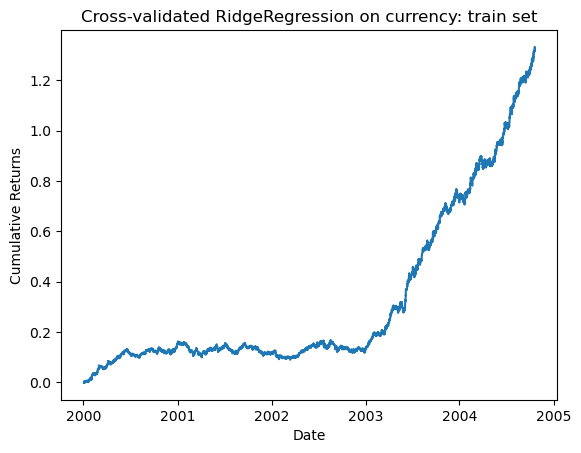

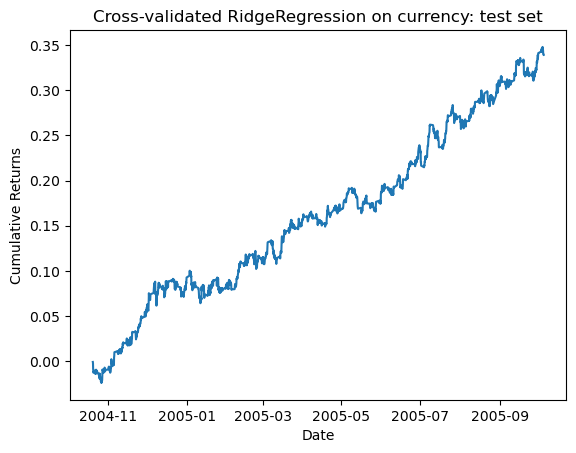

In [26]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(grid_search.predict(x_train.fillna(0))> 0,1,-1 ) #POSITIONS


dailyRet = pd.Series(positions).fillna(0).values * y_train.retFut1 #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1

plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated RidgeRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TrainCumulative"))


cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
s_ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
profits = np.where((dailyRet >= 0), dailyRet, 0)
losses = np.where((dailyRet < 0), dailyRet, 0)
p_ratio = np.sum(profits)/np.sum(np.abs(losses))
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} Profit ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, s_ratio, p_ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

# Test set
# Make "predictions" on test set (out-of-sample)
#positions2 = np.where(best_model.predict(x_test)> 0,1,-1 ) 
positions2 = np.where(grid_search.predict(x_test.fillna(0))> 0,1,-1 ) #POSITIONS


dailyRet2 = pd.Series(positions2).fillna(0).values * y_test.retFut1 #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

plt.figure(2)
plt.plot(cumret2.index, cumret2)
plt.title('Cross-validated RidgeRegression on currency: test set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TestCumulative"))

rho, pval = spearmanr(y_test,grid_search.predict(x_test)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
s_ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
profits = np.where((dailyRet2 >= 0), dailyRet2, 0)
losses = np.where((dailyRet2 < 0), dailyRet2, 0)
p_ratio = np.sum(profits)/np.sum(np.abs(losses))
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} Profit ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, s_ratio, p_ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))


In [27]:
print(
    ('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} Profit ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, s_ratio, p_ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))


In [28]:
('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} Profit ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, s_ratio, p_ratio, maxDD, maxDDD.astype(int), -cagr/maxDD)

'Out-of-sample: CAGR=0.0374672 Sharpe ratio=1.15138 Profit ratio=1.22782 maxDD=-0.0327017 maxDDD=221 Calmar ratio=1.14572\n'

In [12]:
print(cagr, s_ratio, p_ratio, maxDD, maxDDD)
for i in [cagr, s_ratio, p_ratio, maxDD, maxDDD]:
    print(i)

print(cagr)
cagr
type(cagr)
print('hey')
try:
    print("CAGR:", cagr)
except Exception as e:
    print("Failed to print:", e)



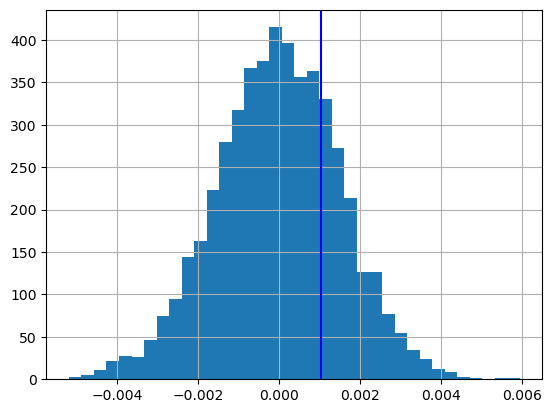

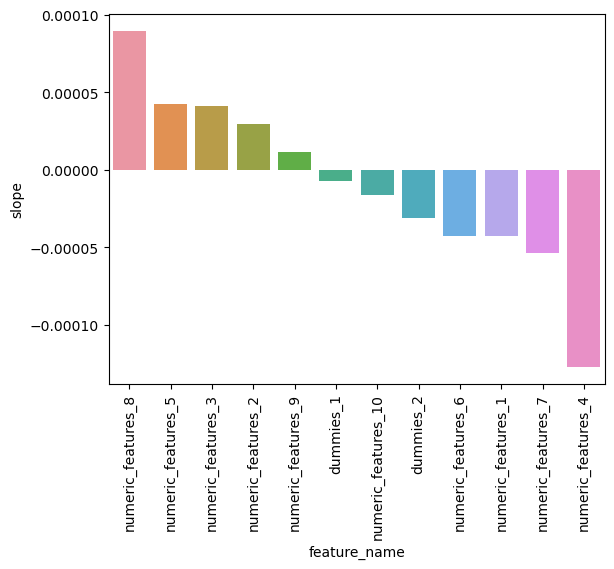

In [10]:
#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
# sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
sns.histplot(residuals, kde=True, stat='density', ax=axes[0], label='Residuals', color='blue')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
#plt.show()
plt.savefig(r'Results\%s.png' %("Residuals"))
plt.close("all") 

#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb.iloc[0,1])

#Detrending Prices and Returns and white reality check
detrended_open = detrendPrice.detrendPrice(openp[10000:12000])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
plt.show()


column_names = []
num_numeric = int(len(numeric_features_ix)*percentile/100)
for i in range(1,num_numeric+1):
    column_names.append('numeric_features_'+str(i))
num_dummies = len(best_model[1].coef_.ravel().tolist())-num_numeric
for i in range(1,num_dummies+1):
    column_names.append('dummies_'+str(i))

##plot the coefficients
importance = pd.DataFrame(zip(best_model[1].coef_.ravel().tolist(), column_names))
importance.columns = ['slope','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)
#plt.show()
plt.savefig(r'Results\%s.png' %("Coefficients"))




